<a href="https://colab.research.google.com/github/nhquynhhh/IS403_O21_2/blob/week7_hoangmanhthang/Model/FEDformer/KDH_FEDformer_7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# !pip install neuralforecast

In [115]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset


In [116]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [117]:
df = pd.read_csv('KDH-Historical-Data.csv')

In [118]:
df1 = df

In [119]:

df1['unique_id'] = 'KDH'
df1

,Date,Price,unique_id
0,2017-01-03,9198.4,KDH
1,2017-01-04,9198.4,KDH
2,2017-01-05,8944.8,KDH
3,2017-01-06,9083.2,KDH
4,2017-01-07,9106.2,KDH
...,...,...,...
2702,2024-05-28,36250.0,KDH
2703,2024-05-29,35700.0,KDH
2704,2024-05-30,36050.0,KDH
2705,2024-05-31,36200.0,KDH


In [120]:
df1 = df1[['unique_id', 'Date', 'Price']]
df1

,unique_id,Date,Price
0,KDH,2017-01-03,9198.4
1,KDH,2017-01-04,9198.4
2,KDH,2017-01-05,8944.8
3,KDH,2017-01-06,9083.2
4,KDH,2017-01-07,9106.2
...,...,...,...
2702,KDH,2024-05-28,36250.0
2703,KDH,2024-05-29,35700.0
2704,KDH,2024-05-30,36050.0
2705,KDH,2024-05-31,36200.0


In [121]:
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,KDH,2017-01-03,9198.4
1,KDH,2017-01-04,9198.4
2,KDH,2017-01-05,8944.8
3,KDH,2017-01-06,9083.2
4,KDH,2017-01-07,9106.2
...,...,...,...
2702,KDH,2024-05-28,36250.0
2703,KDH,2024-05-29,35700.0
2704,KDH,2024-05-30,36050.0
2705,KDH,2024-05-31,36200.0


In [122]:
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)


In [123]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707 entries, 0 to 2706
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2707 non-null   object        
 1   ds         2707 non-null   datetime64[ns]
 2   y          2707 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 63.6+ KB


In [124]:
size = int(len(df1))

In [125]:
train_data = df1[:int(0.7 *size)]
test_data = df1[int(0.7 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1894
Test lenght: 813


In [126]:
train_data

,unique_id,ds,y
0,KDH,2017-01-03,9198.4
1,KDH,2017-01-04,9198.4
2,KDH,2017-01-05,8944.8
3,KDH,2017-01-06,9083.2
4,KDH,2017-01-07,9106.2
...,...,...,...
1889,KDH,2022-03-07,48909.0
1890,KDH,2022-03-08,47364.0
1891,KDH,2022-03-09,46545.0
1892,KDH,2022-03-10,46818.0


In [131]:
model = FEDformer(h=test_len+90,
                 input_size=365,
                 modes=64,
                 hidden_size=128,
                 n_head=8,
                 loss=MAE(),
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=200,
                 batch_size=32,
                 windows_batch_size=256,
                )

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=train_data, static_df=None, verbose=True)
forecasts = nf.predict()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 384   
5 | dec_embedding | DataEmbedding | 384   
6 | encoder       | Encoder       | 279 K 
7 | decoder       | Decoder       | 403 K 
------------------------------------------------
683 K    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [132]:
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [133]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]


In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 14897.480363045817
Mean Absolute Percentage Error (MAPE): 0.5109892075074836
Root Mean Square Error (RMSE): 16468.39950173081


In [135]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)


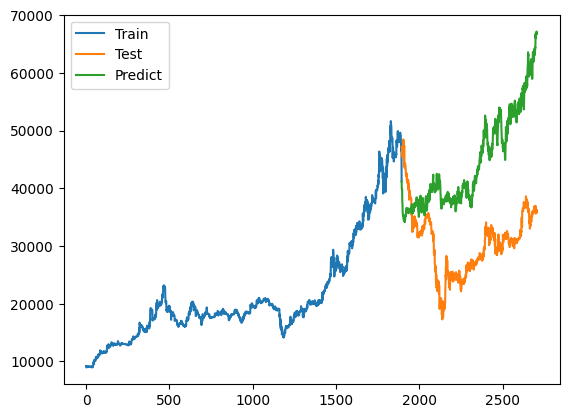

In [136]:
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(predict_test_index,(predict_test))
plt.legend(['Train','Test','Predict'])
plt.show()



In [137]:
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]


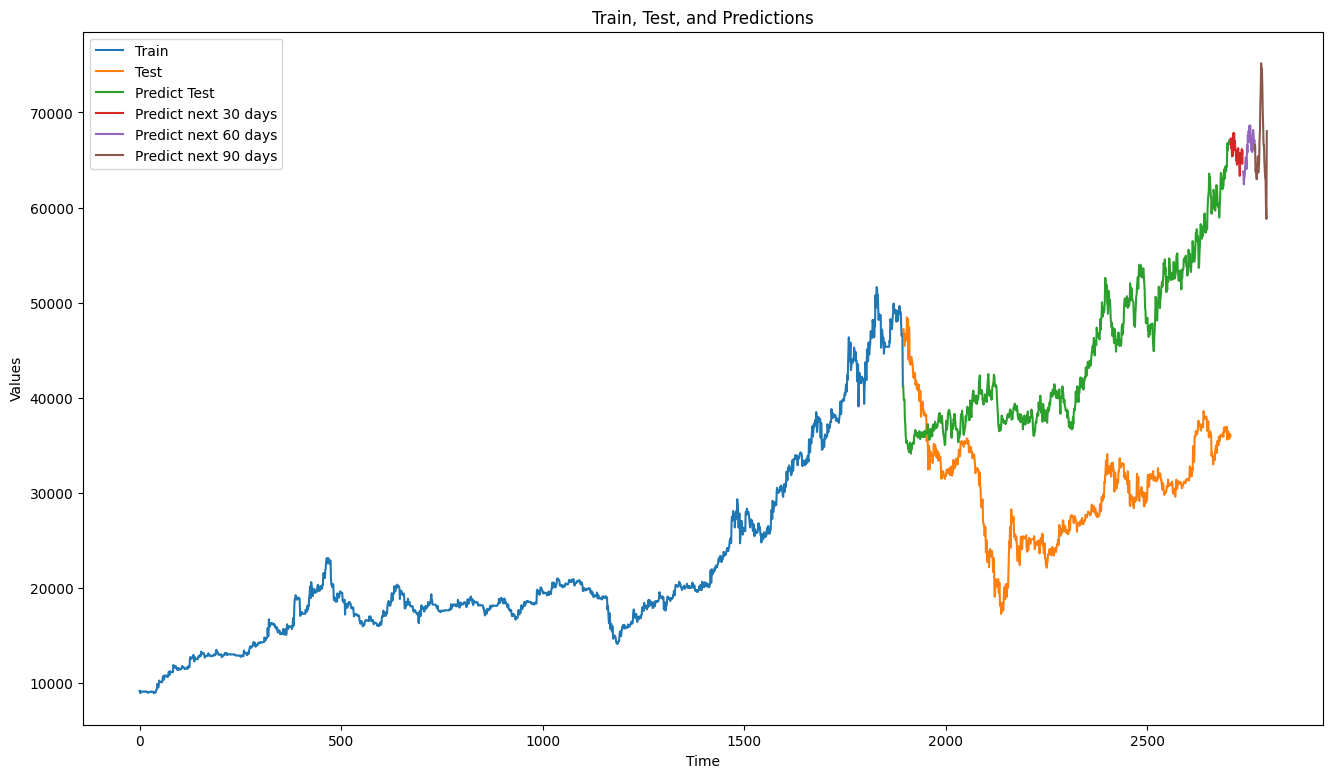

In [138]:
plt.figure(figsize=(16, 9))
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))
predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)
plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()
